# MNIST and CNN architecture

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
# calling the dataset
from tensorflow.keras.datasets import mnist

# access the training and test data
(Xtr_raw, Ytr_raw), (Xte_raw, Yte_raw)= mnist.load_data()

(Xtr_raw.shape, Ytr_raw.shape), (Xte_raw.shape, Yte_raw.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

The reshape function changes the dimensions of the data to prepare it for input into the neural network. It reshapes the images into 4D dimensions with the size of (number of samples, image height, image width, number of channels). In MNIST, the dimensions of the images are (60000, 28, 28), which are reshaped to (60000, 1, 28, 28). This is necessary to match the input size of the neural network layers.

In [ ]:
# data reformating - adding a channel dimension
Xtr_raw= np.expand_dims(Xtr_raw, 1) # Grayscale images have 1 channel
Xte_raw= np.expand_dims(Xte_raw, 1)

Xtr_raw.shape

(60000, 1, 28, 28)

# Data processing

Some datasets, like MNIST, require minimal processing, but real-world data is not always so straightforward.

If normalization is not performed, one of the issues that arises is convergence problems, which may result in the model converging slowly or not converging at all. There are various methods of normalization. These include Pixel-wise normalization (where each pixel of the image is normalized based on the mean and variance of similar pixels in the dataset), Local Contrast normalization (useful for images with local brightness variations, where each region of the image is normalized relative to similar regions in all data), Robust Scaling (which uses the median and interquartile range of the data for scaling, making it robust against outliers), and Unit Vector Scaling (where each row of the data is normalized in such a way that the sum of squares of its values equals one).

The Min-Max Scaling method is more suitable for data with a normal distribution or similar. When the data have a non-normal distribution, such as MNIST, the Z-score method is usually more useful because it normalizes the data based on the mean and variance.

In [ ]:
# For the MNIST dataset, normalization may be useful but often not necessary.
# We will just subtract the mean image for centering (e.g., AlexNet)
# see https://www.youtube.com/watch?v=gYpoJMlgyXA

# convert data to float32
Xtr_raw= Xtr_raw.astype(np.float32)
Xte_raw= Xte_raw.astype(np.float32)

# calculate the mean of the training data
Xmean= np.mean(Xtr_raw)

# apply the centering to the training data
Xtr_raw -= Xmean

# apply the centering to the test data using the mean of the training data
Xte_raw -= Xmean

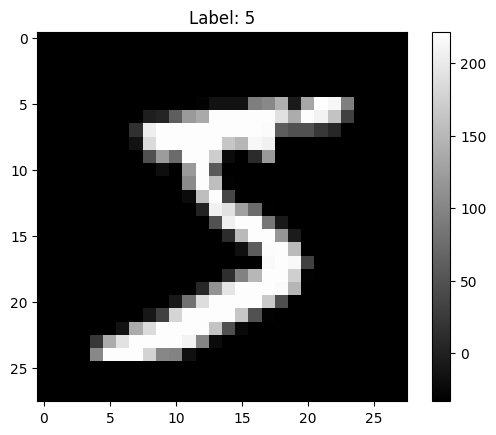

In [ ]:
# rendering one example
plt.imshow(Xtr_raw[0][0], cmap='gray')
plt.colorbar()
plt.title(f'Label: {Ytr_raw[0]}')
plt.show()

In [ ]:
# setting the device
device= 'cuda' if torch.cuda.is_available() else 'cpu'

# converting data to pytorch type
Xtr= torch.tensor(Xtr_raw, requires_grad=True).to(device)
Ytr= torch.tensor(Ytr_raw).to(device)
Xte= torch.tensor(Xte_raw, requires_grad=True).to(device)
Yte= torch.tensor(Yte_raw).to(device)

# transforming labels from numbers to one-hot vectors of length 10
Ytr= F.one_hot(Ytr.type(torch.int64), num_classes=10).type(torch.float32)
Yte= F.one_hot(Yte.type(torch.int64), num_classes=10).type(torch.float32)

# creating a dev dataset from training data
tr_size= int(0.8*Xtr.shape[0])

Xdev= Xtr[tr_size:]
Ydev= Ytr[tr_size:]

Xtr= Xtr[:tr_size]
Ytr= Ytr[:tr_size]

print(f'Shape of training: Xtr - {Xtr.shape}, Ytr - {Ytr.shape}')
print(f'Shape of dev data: Xdev - {Xdev.shape}, Ydev - {Ydev.shape}')
print(f'Shape of test data: Xte - {Xte.shape}, Yte - {Yte.shape}')

Shape of training: Xtr - torch.Size([48000, 1, 28, 28]), Ytr - torch.Size([48000, 10])
Shape of dev data: Xdev - torch.Size([12000, 1, 28, 28]), Ydev - torch.Size([12000, 10])
Shape of test data: Xte - torch.Size([10000, 1, 28, 28]), Yte - torch.Size([10000, 10])


# Architecture Design (Model Building)

Using PyTorch to create a modified, smaller version of AlexNet. This model has two general parts: the convolutional backbone and the densely connected head.

CNNs operate over volumes; all of the layers in between are going to take volumes of activations and are going to produce volumes of activations, so the intermediates are not as vectors lake NNs, but they have spatial dimensions (width, height, and depth -- or channels) that will maintain the computations.

https://www.youtube.com/watch?v=LxfUGhug-iQ

In [ ]:
class Activation(nn.Module):
    """
    Activation functions implemented: relu, tanh.
    """

    def __init__(self, activation='relu') -> None:
        super(Activation, self).__init__()
        if 'relu' in activation:
            self.activ= nn.ReLU()
        else:
            self.activ= nn.Tanh()


    def forward(self, x):

        return self.activ(x)


For deep convolutional networks, it is necessary to define padding values; otherwise, the convolutional operation will always decrease the input size (spatial downsampling), and this is not we might want necessarily because if we collapse the size of our representation too quickly, then the total amount of convolutional layers (depth) is limited. For 3x3 kernels, paddings of 1 keep the input space (with stride=1). The spatial downsampling procedure is managed by applying pooling layers (preserving the volume of the convolution).

AlexNet (8 layers, 60M parameters) - Input image: 227x227x3
- 1st layer (conv) 96 11x11 filters, stride 4. Output volume: 55x55x96. Parameters (11x11x3)x96 = 35K
- 2nd layer (pool) 3x3 filters, stride 2. Output volume: 27x27x96 ((55-3)/2+1 = 27). Pool layers have zero parameters.
- 3rd layer - normalization
- 4st layer (conv) ...
- Output volume at the end of the Backbone module: 6x6x256
- Head - two FC layers with 4096 neurons each
- Output (class scores) 1000 neurons

AlexNet details: ReLU, dropout 0.5, batch size 128, SGD Momentum 0.9, learning rate 1e-2 manually reduced by 10, L2 weight decay 5e-4.

VGGNet (19 layers): only 3x3 conv with stride 1 and pad 1, and Max Pool stride 2. Spacially decreases the input but the volumes of convs get more depth (output volume of backbone is 7x7x512).

ResNet: Xavier/2 init, batch norm after every conv layer, no dropout, batch size 256, SGD Momentum 0.9, learning rate 0.1 reduced by 10 when validation error plateaus, weight decay 1e-5. Very deep architecture (152 layers) introduces residual (skip) connections (the input flows in, but instead of computing how to transform the input, ResNet computes what to add to the input). In the backward pass, skip connections allow the gradient to skip right through the layers, preventing it vanishes.

https://www.youtube.com/watch?v=LxfUGhug-iQ

In [ ]:
class CNN_Layer(nn.Module):
    """
    Implements one CNN layer.
    """

    def __init__(self, in_chs, out_chs, kernel, conv_stride, padding,
                 max_pool, pool_stride, norm, activation, dropout) -> None:
        super(CNN_Layer, self).__init__()
        self.conv= nn.Conv2d(in_chs, out_chs, kernel, conv_stride, padding)
        self.max_pool= None
        if max_pool> 0.0:
            self.max_pool= nn.MaxPool2d(max_pool, pool_stride) # Max pooling layer
        self.norm= None
        if norm:
            self.norm= nn.BatchNorm2d(out_chs)                 # Adding Batch Normalization layer
        self.activ= Activation(activation)
        self.dropout= None
        if dropout> 0.0:
            self.dropout= nn.Dropout(p=dropout)                # Dropout layer for regularization


    def forward(self, x):
        x= self.conv(x)
        if self.max_pool is not None:
            x= self.max_pool(x)
        if self.norm is not None:
            x= self.norm(x)
        x= self.activ(x)
        if self.dropout is not None:
            x= self.dropout(x)

        return x



class Backbone(nn.Module):
    """
    Defining the CNN backbone.
    """

    def __init__(self, input_chs, output_chs, hidden_chs=[16,], kernels=3, conv_strides=1, paddings=0,
                 max_pool=2, pool_strides=2,
                 norm=False, activation='relu', dropout=0.0) -> None:
        super(Backbone, self).__init__()
        if isinstance(hidden_chs, int):
            if hidden_chs== 0:
                raise Exception('hidden_chs cannot be zero')
            hidden_chs= [hidden_chs]
        n_hidden_layers= len(hidden_chs)

        if n_hidden_layers== 0:
            raise Exception('hidden_chs cannot be an empty list')

        def check_hparams(hparam):
            if isinstance(hparam, int):
                hparam= [hparam for _ in range(n_hidden_layers+1)]
            elif len(hparam)< n_hidden_layers+1:
                hparam_name= [name for name, value in globals().items() if value is hparam][0]
                raise Exception(hparam_name + ' list should be defined for each conv layer')
            return hparam

        kernels= check_hparams(kernels)
        conv_strides= check_hparams(conv_strides)
        paddings= check_hparams(paddings)
        max_pool= check_hparams(max_pool)
        pool_strides= check_hparams(pool_strides)

        self.conv_in= CNN_Layer(input_chs, hidden_chs[0], kernels[0], conv_strides[0], paddings[0],
                                max_pool[0], pool_strides[0], norm, activation, dropout)

        if n_hidden_layers> 1:
            self.conv_hn= nn.Sequential(*[
                CNN_Layer(ch, hidden_chs[i+1], k, cs, p, m, ps, norm, activation, dropout)
                for i, (ch, k, cs, p, m, ps) in enumerate(zip(hidden_chs[:-1],
                                                 kernels[1:-1], conv_strides[1:-1], paddings[1:-1],
                                                 max_pool[1:-1], pool_strides[1:-1]))
            ])
        else: self.conv_hn= None

        self.conv_out= CNN_Layer(hidden_chs[-1], output_chs, kernels[-1], conv_strides[-1], paddings[-1],
                                 max_pool[-1], pool_strides[-1], norm, activation, dropout)


    def forward(self, x):
        x= self.conv_in(x)
        if self.conv_hn is not None:
            x= self.conv_hn(x)
        x= self.conv_out(x)

        return torch.flatten(x, 1) # Flatten last layer to convert 2D matrix to a vector


In [ ]:
class MLP_Layer(nn.Module):
    """
    Implements one MLP hidden layer.
    """

    def __init__(self, in_dim, out_dim, norm, activation, dropout) -> None:
        super(MLP_Layer, self).__init__()
        self.fc= nn.Linear(in_dim, out_dim)     # Fully connected layers
        self.norm= None
        if norm:
            self.norm= nn.LayerNorm(out_dim)    # Adding Layer Normalization
        self.activ= Activation(activation)
        self.dropout= None
        if dropout> 0.0:
            self.dropout= nn.Dropout(p=dropout) # Dropout layer for regularization


    def forward(self, x):
        x= self.fc(x)
        if self.norm is not None:
            x= self.norm(x)
        x= self.activ(x)
        if self.dropout is not None:
            x= self.dropout(x)

        return x



class Head(nn.Module):
    """
    Defining the MLP Projection Head (for data classification).
    """

    def __init__(self, input_dim, n_classes=1, hidden_dim=[16,], norm=False,
                 activation='relu', dropout=0.0) -> None:
        super(Head, self).__init__()
        if isinstance(hidden_dim, int):
            if hidden_dim== 0:
                raise Exception('hidden_dim cannot be zero')
            hidden_dim= [hidden_dim]
        n_hidden_layers= len(hidden_dim)

        if n_hidden_layers== 0:
            raise Exception('hidden_dim cannot be an empty list')

        self.fc_in= MLP_Layer(input_dim, hidden_dim[0], norm, activation, dropout)

        if n_hidden_layers> 1:
            self.fc_hn= nn.Sequential(*[
                MLP_Layer(d, hidden_dim[i+1], norm, activation, dropout)
                for i, d in enumerate(hidden_dim[:-1])
            ])
        else: self.fc_hn= None

        self.fc_out= nn.Linear(hidden_dim[-1], n_classes)


    def forward(self, x):
        x= self.fc_in(x)
        if self.fc_hn is not None:
            x= self.fc_hn(x)
        x= self.fc_out(x)

        return F.log_softmax(x, dim=1) # Output layer with softmax activation for classification


In [ ]:
class CNN_Model(nn.Module):
    """
    Defining the full model - Feature extractor backbone + classification (projection) head.
    """

    def __init__(self, input_chs, output_chs, hidden_chs=[16,], kernels=3, conv_strides=1, paddings=0,
                 max_pool=2, pool_strides=2,                          # CNN
                 input_dim=1, n_classes=1, hidden_dim=[16,],          # MLP
                 norm=False, activation='relu', dropout=0.0) -> None:
        super(CNN_Model, self).__init__()
        self.backbone= Backbone(
            input_chs, output_chs, hidden_chs, kernels, conv_strides, paddings,
            max_pool, pool_strides, norm, activation, dropout
        )
        self.head= Head(
            input_dim, n_classes, hidden_dim, norm, activation, dropout
        )
        # Initialize parameters with Glorot et al., 2010 / fan_avg
        for p in self.parameters():
            if p.dim()> 1:
                nn.init.xavier_uniform_(p)


    def forward(self, x):
        x= self.backbone(x)
        x= self.head(x)

        return x


BatchNorm normalizes each feature within a batch of samples, while LayerNorm normalizes all features within each sample. Let's assume we have a two-dimensional input matrix, where the rows represent the batch and the columns represent the sample features. The target of Batch Normalization is a batch of samples (horizontal), and the target of Layer Normalization is a single sample (vertical).

For the field of computer vision, features depend on the statistical parameters between different samples, and **BatchNorm** is more effective. This is because it eliminates the size relationship between different features while preserving the size relationship between different samples.

In the field of NLP, **LayerNorm** is more appropriate. This is because the different features of a single sample are actually the variations in words over time, and the feature relationships within the sample are very close.

Typical architectures look like: [(Conv-ReLU)xN-Pool?]xM-(FC-ReLU)xK,Softmax
- where N is usually up to ~5, M is large, 0<= K <=2.
- but advances such as ResNet/GoogLeNet challenge this paradigm.

https://www.youtube.com/watch?v=LxfUGhug-iQ

In [ ]:
# ----- Backbone defs -----
input_chs= Xtr.shape[1] # the data is single-channel (grayscale)
hidden_chs=[32,64,]     # represents the number of filters used in each convolutional layer
output_chs= 64          # number of channels in the output
kernels=3               # represents the dimensions of the kernel or filter, which collects information from the images
conv_stride=1           # controls the stride for the cross-correlation, default is 1
paddings=1              # controls the amount of padding applied to each conv layer
max_pool=2              # performs pooling operations on the images
pool_stride=max_pool    # the stride of the window. Default value is pool_size
# ----- Head defs -----
input_dim= 576
hidden_dim=[64,32,]     # dense (fully connected) layers
n_classes=10            # digits from 0 to 9
# ----- general defs -----
norm=True
activation='relu'
dropout=0.1


model= CNN_Model(input_chs, output_chs, hidden_chs, kernels, conv_stride, paddings,
                 max_pool, pool_stride,
                 input_dim, n_classes, hidden_dim, norm, activation, dropout).to(device)

total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

model

Number of parameters: 95594


CNN_Model(
  (backbone): Backbone(
    (conv_in): CNN_Layer(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): Activation(
        (activ): ReLU()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv_hn): Sequential(
      (0): CNN_Layer(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): Activation(
          (activ): ReLU()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (conv_out): CNN_Layer(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

# Training Phase

After constructing the model and its layers with the CNN architecture, the next step is to set the loss function, optimizer, and select evaluation metrics. In machine learning, the loss function represents the difference between the model's output and the actual values. In all tasks, whether in the real world or for solving deep learning problems, one of the most important tasks is to minimize the error.

The optimizer is responsible for optimizing and updating the model's weights (W), adjusting them in a way that minimizes the loss function. Optimizers come in various types such as Adam, SGD, and RMSprop, and selecting the right one for your specific task can help improve the model's performance.

The learning rate determines how small the training steps should be to reach the optimal point. Selecting an appropriate learning rate is crucial in training a model.

Typically, when fitting the model, the first thing we do is specify the number of epochs. In each epoch, the model sees the entire training dataset once to learn complex patterns in the data. Naturally, the higher the number of epochs, the better the model learns because it can see more data, but if it's too high, it may lead to overfitting. In other words, because the model overly converges to the training data, it fails to generalize to new data. In other words, the model simply memorizes the data.

Determining the batch size specifies how many data samples are shown to the model in each epoch. Finding the optimal batch size has a significant impact on the speed and quality of model training. Naturally, a larger batch size is preferable for better performance. However, due to memory constraints, especially in large-scale projects, this may not always be feasible. In diverse datasets, a larger batch size may lead to a loss of model adaptation to the data, resulting in overfitting or underfitting. To prevent this, we can find the best batch size through trial and error or by employing systematic and principled methods such as Grid Search or Validation Data-based approaches.

In [ ]:
def supervised_training(model, learning_rate=1e-3, epochs=500, eval_interval=5, batches=True,
                        batch_size=64, early_stop:bool=True, patience=5, cutoff=1e-9):

    # defining key hyperparamaters explicitly (instead of hyperparamater search)
    if batches:
        epoch_size= round(Xtr.shape[0]/ batch_size)-1
    else:
        batch_size= Xtr.shape[0]
        epoch_size= 1

    weight_decay=5e-4

    # create a PyTorch optimizer
    optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # loss function
    loss_fn= nn.CrossEntropyLoss().to(device)

    # for early stoping
    patience_count= 0
    previous_loss= 1e10

    # tracking statistics
    train_hist= []
    batch_loss= []
    dev_hist= []

    # --- training loop ---
    for epoch in tqdm(range(epochs)):
        # iterating over all batches
        for i in range(epoch_size):

            # --- minibatch construction ---
            Xmb= Xtr[(i * batch_size) : ((i+1) * batch_size)]
            Ymb= Ytr[(i * batch_size) : ((i+1) * batch_size)]

            # --- forward pass and get loss ---
            model.train(True)
            y_pred= model(Xmb)
            loss_tr= loss_fn(y_pred, Ymb)
            batch_loss.append(loss_tr.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss_tr.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()


        # --- evaluation and track stats ---
        train_hist.append(np.mean(batch_loss))
        batch_loss= []

        if epoch% eval_interval== 0:
            model.train(False)
            with torch.no_grad():
                y_pred= model(Xdev)
                loss_dev= loss_fn(y_pred, Ydev)

        dev_hist.append(loss_dev.item())


        # --- early stopping -- calculating loss change ---
        loss_change= np.abs(previous_loss - train_hist[-1])
        # deciding to stop if loss is not decreasing fast enough
        if (early_stop and loss_change< cutoff):
            patience_count += 1

            if patience_count> patience:
                print('\nEarly stopping at epoch {}'.format(epoch))
                model.train(False)
                break
        else:
            patience_count= 0
        # setting current train loss as previous loss
        previous_loss= train_hist[-1]


    # --- final evaluation on the test set ---
    model.train(False)
    with torch.no_grad():
        y_pred= model(Xte)
        #loss_test= loss_fn(y_pred, Yte)
        test_acc= (y_pred.argmax(dim=1)== Yte.argmax(dim=1)).sum().item()/ Yte.shape[0]


    return train_hist, dev_hist, test_acc


Adam note: momentum is keeping track of the first order moment of your gradient; it's summing up the raw gradients and it's keeping an exponential sum. Adagrad is keeping track of the second moment of the gradient and it's exponential sum and what we end up with is Adam. Adam basically take the RMSProp momentum, keeps track of the velocity in a decaying way and that's the step, but then we're also scaling down exponentially adding up a leaky counter of square gradients and so we end up with both Momentum and RMSProp in the same formula. Adam needs some time to "warm up." The experiments show that Adam adapts well to almost any type of neural network architecture taking the advantages of both Momentum and RMSProp.

Dropout: samples smaller versions of the model (similar to the idea of ensembles), making it harder to overfit by forcing the model to be redundant.

https://www.youtube.com/watch?v=hd_KFJ5ktUc

In [ ]:
# https://towardsdatascience.com/understanding-deep-learning-optimizers-momentum-adagrad-rmsprop-adam-e311e377e9c2

In [ ]:
train_hist, dev_hist, test_acc= supervised_training(model, learning_rate=1e-3, epochs=10,
                                                    eval_interval=2, cutoff=1e-6)

100%|██████████| 10/10 [24:13<00:00, 145.40s/it]


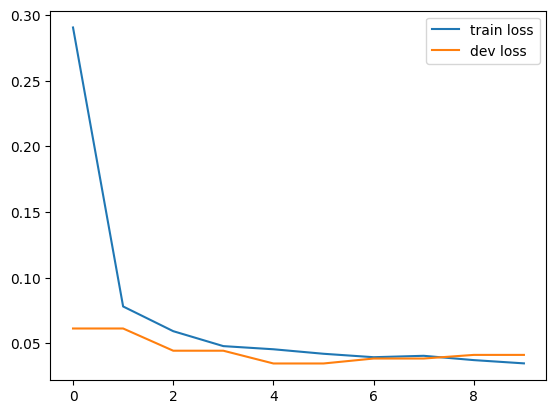

Test accuracy: 0.991


In [ ]:
# ploting
plt.plot(train_hist, label='train loss')
plt.plot(dev_hist, label='dev loss')
plt.legend()
plt.show()

print('Test accuracy: {}'.format(test_acc))

If there isn't much difference between the training accuracy and validation accuracy, meaning they are closer to each other, it indicates that the model hasn't overfit. However, if there is a significant difference, or if the validation accuracy starts decreasing while the training accuracy increases, it's suspicious for overfitting. The accuracy lines should be smoother with fewer fluctuations. The presence of more fluctuations indicates instability in the model's performance, which could be a sign of overfitting.

If the Training Accuracy is continuously decreasing while the Validation Accuracy starts to increase or remains stable, this indicates overfitting. Conversely, if both training and validation accuracies consistently decrease or remain stable at similar levels, it indicates that the model has effectively learned. Ideally, we aim to steadily increase both Training and Validation accuracies or stabilize them at similar levels.

In [ ]:
# Small version

# ----- Backbone defs -----
input_chs= Xtr.shape[1] # the data is single-channel (grayscale)
hidden_chs=[16,16,]     # represents the number of filters used in each convolutional layer
output_chs= 32          # number of channels in the output
kernels=3               # represents the dimensions of the kernel or filter, which collects information from the images
conv_stride=1           # controls the stride for the cross-correlation, default is 1
paddings=1              # controls the amount of padding applied to each conv layer
max_pool=2              # performs pooling operations on the images
pool_stride=max_pool    # the stride of the window. Default value is pool_size
# ----- Head defs -----
input_dim= 288
hidden_dim=[32,16,]     # dense (fully connected) layers
n_classes=10            # digits from 0 to 9
# ----- general defs -----
norm=True
activation='relu'
dropout=0.1


model2= CNN_Model(input_chs, output_chs, hidden_chs, kernels, conv_stride, paddings,
                  max_pool, pool_stride,
                  input_dim, n_classes, hidden_dim, norm, activation, dropout).to(device)

total_params= sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

model2

Number of parameters: 17290


CNN_Model(
  (backbone): Backbone(
    (conv_in): CNN_Layer(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): Activation(
        (activ): ReLU()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv_hn): Sequential(
      (0): CNN_Layer(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): Activation(
          (activ): ReLU()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (conv_out): CNN_Layer(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [ ]:
train_hist, dev_hist, test_acc= supervised_training(model2, learning_rate=1e-3, epochs=10,
                                                    eval_interval=2, cutoff=1e-6)

100%|██████████| 10/10 [24:17<00:00, 145.76s/it]


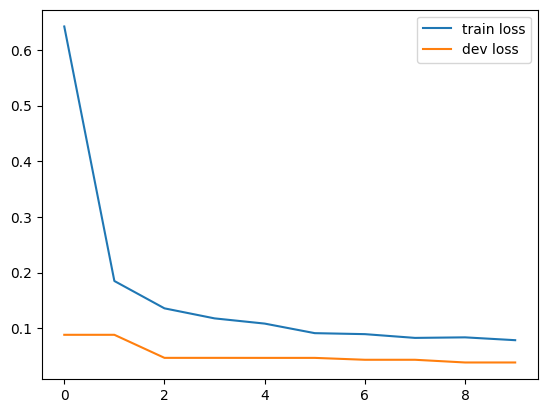

Test accuracy: 0.9913


In [ ]:
# ploting
plt.plot(train_hist, label='train loss')
plt.plot(dev_hist, label='dev loss')
plt.legend()
plt.show()

print('Test accuracy: {}'.format(test_acc))

Small version trained using a large batch_size value -- improvement in the training time without significantly degrading test accuracy.

Errors start larger than previously and quickly reduce.

In [ ]:
# ----- reseting the model -----
model2= CNN_Model(input_chs, output_chs, hidden_chs, kernels, paddings, max_pool,
                  input_dim, n_classes, hidden_dim, norm, activation, dropout).to(device)

train_hist, dev_hist, test_acc= supervised_training(model2, learning_rate=1e-3, epochs=10,
                                                    batch_size=256, eval_interval=2, cutoff=1e-6)

100%|██████████| 10/10 [06:10<00:00, 37.07s/it]


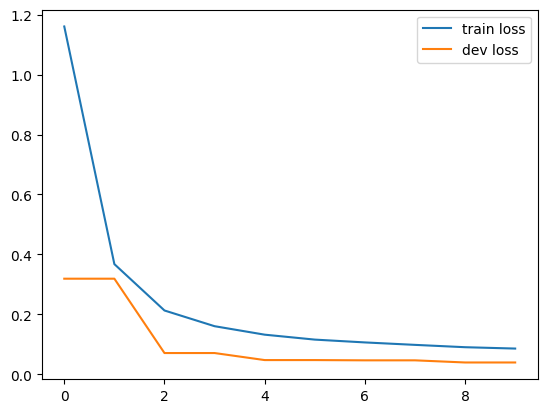

Test accuracy: 0.9909


In [ ]:
# ploting
plt.plot(train_hist, label='train loss')
plt.plot(dev_hist, label='dev loss')
plt.legend()
plt.show()

print('Test accuracy: {}'.format(test_acc))

In [ ]:
# https://ai.gopubby.com/step-by-step-guide-to-building-an-artificial-neural-network-and-observing-how-overfitting-occurs-84961f96c7e8

# AlexNet

Just building the model and testing with a dummy sample.

In [ ]:
# ----- Backbone defs -----
input_chs= 3                 # the data is single-channel (grayscale)
hidden_chs=[96,256,384,384,] # represents the number of filters used in each convolutional layer
output_chs= 256              # number of channels in the output
kernels=[11,5,3,3,3,]        # represents the dimensions of the kernel or filter, which collects information from the images
conv_stride=[4,1,1,1,1,]
paddings=[0,2,1,1,1,]        # controls the amount of padding applied to each conv layer
max_pool=[3,3,0,0,3,]        # performs pooling operations on the images
pool_stride=[2,2,0,0,2,]
# ----- Head defs -----
input_dim= 9216
hidden_dim=[4096,4096,]      # dense (fully connected) layers
n_classes=1000               # digits from 0 to 9
# ----- general defs -----
norm=True                    # note: the original AlexNet has norms only in conv layers 1 and 2
activation='relu'
dropout=0.1


AlexNet= CNN_Model(input_chs, output_chs, hidden_chs, kernels, conv_stride, paddings,
                   max_pool, pool_stride,
                   input_dim, n_classes, hidden_dim, norm, activation, dropout).to(device)

total_params= sum(p.numel() for p in AlexNet.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

AlexNet

Number of parameters: 62397480


CNN_Model(
  (backbone): Backbone(
    (conv_in): CNN_Layer(
      (conv): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
      (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): Activation(
        (activ): ReLU()
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (conv_hn): Sequential(
      (0): CNN_Layer(
        (conv): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): Activation(
          (activ): ReLU()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): CNN_Layer(
        (conv): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNo

In [ ]:
# test sample
Xtr_imageNet= torch.randint(low=0, high=255, size=(1,3,227,227)).type(torch.float32).to(device)
Xtr_imageNet.shape

torch.Size([1, 3, 227, 227])

In [ ]:
# testing the model - it works!
AlexNet(Xtr_imageNet).shape

torch.Size([1, 1000])